# nbeats 실험 추세성, 잔차
---
- 샘플사이즈에 따른 최적 에포크
- 시뮬레이션 데이터 
    - 추세
    - 잔차

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nbeats_keras.model import NBeatsNet as NBeatsKeras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#from nbeats_pytorch.model import NBeatsNet as NBeatsPytorch
from keras.optimizers import RMSprop, Adam
import time
#from pretraindata_simulation72_24_scale import sclae_X_train,sclae_y_train

from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Lambda
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
##############################################################################################################
def window(df, timestep):
    '''
    단변량 데이터를 timestep에 따라 window로 생성하는 함수
    
    '''
    for i in range(0, timestep):
        df['shift_{}'.format(i)] = df.iloc[:,0].shift(i)
        df['shift_{}'.format(i)] = df.iloc[:,0].shift(i)
    window_df = df.dropna(axis=0) # 결측치 공간 제거
    window_df = window_df.iloc[:,::-1] # 좌우 반전


    feature= window_df.iloc[:,:-1].values
    y_label= window_df.iloc[:,-1].values

    return feature

##############################################################################################################
def generate_time(t,    
                  cosine_period1=24,
                    cosine_period2=1,
                    cosine_period3=1,
                    sine_period1=1,
                    sine_period2=1,
                    sine_period3=1,
                    cosine_slope1=1,
                    cosine_slope2=2,
                    cosine_slope3=3,
                    sine_slope1=1,
                    sine_slope2=2,
                    sine_slope3=3,
                    trend_slope = 0,
                  noise_level=0.1):
    '''
    cosin, sin, trend, 기울기 등을 결합하여 데이터 생성
    y = b1*cos(2*pi*t/period) + b2*cos(2*pi*t/period) + b3*t + epsilon
    '''
    series = (cosine_slope1 * np.cos(2 * np.pi / cosine_period1 * (t )) +
              cosine_slope2 * np.cos(2 * np.pi / cosine_period2 * (t )) +
              cosine_slope3 * np.cos(2 * np.pi / cosine_period3 * (t )) +
              sine_slope1 * np.sin(2 * np.pi / sine_period1 * (t )) + 
              sine_slope2 * np.sin(2 * np.pi / sine_period2 * (t )) + 
              sine_slope3 * np.sin(2 * np.pi / sine_period3 * (t )) + 
              trend_slope * t )


    # Add Gaussian noise
    noise = noise_level * np.random.randn(len(t))
    series += noise

    return series
##############################################################################################################

def random_parameters():
    '''
    랜덤 파라미터
    '''
    cosine_slope1=round(np.random.uniform(-1,1),2),
    cosine_slope2=round(np.random.uniform(-1,1),2),
    cosine_slope3=round(np.random.uniform(-1,1),2),
    sine_slope1=round(np.random.uniform(-1,1),2),
    sine_slope2=round(np.random.uniform(-1,1),2),
    sine_slope3=round(np.random.uniform(-1,1),2)

    return cosine_slope1,cosine_slope2,cosine_slope3,sine_slope1,sine_slope2,sine_slope3
##############################################################################################################

def generate_random_ts(t):
    '''
    랜덤 파라미터에 의한 데이터 생성
    '''
    cosine_slope1,cosine_slope2,cosine_slope3,sine_slope1,sine_slope2,sine_slope3= random_parameters()
    
    random_ts= generate_time(t,
                            cosine_slope1 = cosine_slope1,
                             cosine_slope2 = cosine_slope2,
                             cosine_slope3=cosine_slope3,
                             sine_slope1 = sine_slope1,
                             sine_slope2= sine_slope2,
                             sine_slope3=sine_slope3)
    
    return random_ts
##############################################################################################################

def split_train_test(list_in_array, horizon, lookback):
    '''
    train_test 모형 적합 전처리 함수
    1. train, test 분리
    2. input, output 분리
    '''
    
    train = np.array([list_in_array[i][:-horizon*(lookback+1)] for i in range(len(list_in_array))])
    test = np.array([list_in_array[i][-horizon*(lookback+1):] for i in range(len(list_in_array))])
    #from sklearn.preprocessing import MinMaxScaler
    #minmax = MinMaxScaler()
    #scale = minmax.fit_transform(pd.concat([pd.DataFrame(train), pd.DataFrame(test)],axis=1))
    
    #train = np.array([scale[i][:-horizon*(lookback+1)] for i in range(len(scale))])
    #test = np.array([scale[i][-horizon*(lookback+1):] for i in range(len(scale))])
    
    window_train= [window(pd.DataFrame(train[i]),horizon*(lookback+1)) for i in range(len(train))]
    X_train = [window_train[i][:,:-horizon] for i in range(len(window_train))]
    y_train = [window_train[i][:,-horizon:] for i in range(len(window_train))]
    X_test = test[:,:-horizon]#.reshape(-1,1)
    y_test = test[:,-horizon:]#.reshape(-1,1)
    
    X_test = [X_test[i].reshape(1,-1) for i in range(len(X_test))]
    y_test = [y_test[i].reshape(1,-1) for i in range(len(y_test))]
    
    
    return X_train ,y_train, X_test,y_test



In [71]:
np.random.seed(100)

horizon = 24
lookback = 3
t = 1191
t1000 = np.arange(0,t)
e = np.random.normal(0,1,t)

random_simul_yt = []
for i in range(15):
    ramdom_ts = generate_time(t1000 ,24,12,6,24,12,6,
                               round(np.random.uniform(-3,3),2),
                               round(np.random.uniform(-3,3),2),
                               round(np.random.uniform(-3,3),2),
                               round(np.random.uniform(-3,3),2),
                               round(np.random.uniform(-3,3),2),
                               round(np.random.uniform(-3,3),2),
                               0.5,0) + e
    np.array(random_simul_yt.append(ramdom_ts ))
   

    
    
random_simul_nt = []
for i in range(15):
    ramdom_ts = generate_time(t1000 ,24,12,6,24,12,6,
                               round(np.random.uniform(-3,3),2),
                               round(np.random.uniform(-3,3),2),
                               round(np.random.uniform(-3,3),2),
                               round(np.random.uniform(-3,3),2),
                               round(np.random.uniform(-3,3),2),
                               round(np.random.uniform(-3,3),2),
                               0,0) + e
    np.array(random_simul_nt.append(ramdom_ts ))
    
random_simul_yt = []
for i in range(15):
    ramdom_ts = generate_time(t1000 ,24,12,6,24,12,6,
                               round(np.random.uniform(-3,3),2),
                               round(np.random.uniform(-3,3),2),
                               round(np.random.uniform(-3,3),2),
                               round(np.random.uniform(-3,3),2),
                               round(np.random.uniform(-3,3),2),
                               round(np.random.uniform(-3,3),2),
                               0.5,0) + e
    np.array(random_simul_yt.append(ramdom_ts ))
   

    
    
random_simul_le = []
for i in range(15):
    ramdom_ts = generate_time(t1000 ,24,12,6,24,12,6,
                               round(np.random.uniform(-3,3),2),
                               round(np.random.uniform(-3,3),2),
                               round(np.random.uniform(-3,3),2),
                               round(np.random.uniform(-3,3),2),
                               round(np.random.uniform(-3,3),2),
                               round(np.random.uniform(-3,3),2),
                               0,0) + e/3
    np.array(random_simul_le.append(ramdom_ts ))

    
random_simul_he = []
for i in range(15):
    ramdom_ts = generate_time(t1000 ,24,12,6,24,12,6,
                               round(np.random.uniform(-3,3),2),
                               round(np.random.uniform(-3,3),2),
                               round(np.random.uniform(-3,3),2),
                               round(np.random.uniform(-3,3),2),
                               round(np.random.uniform(-3,3),2),
                               round(np.random.uniform(-3,3),2),
                               0,0) + e*3
    np.array(random_simul_he.append(ramdom_ts ))
#plt.plot(np.array(random_simul).T[:100]);

## 적합 데이터 시도표 1

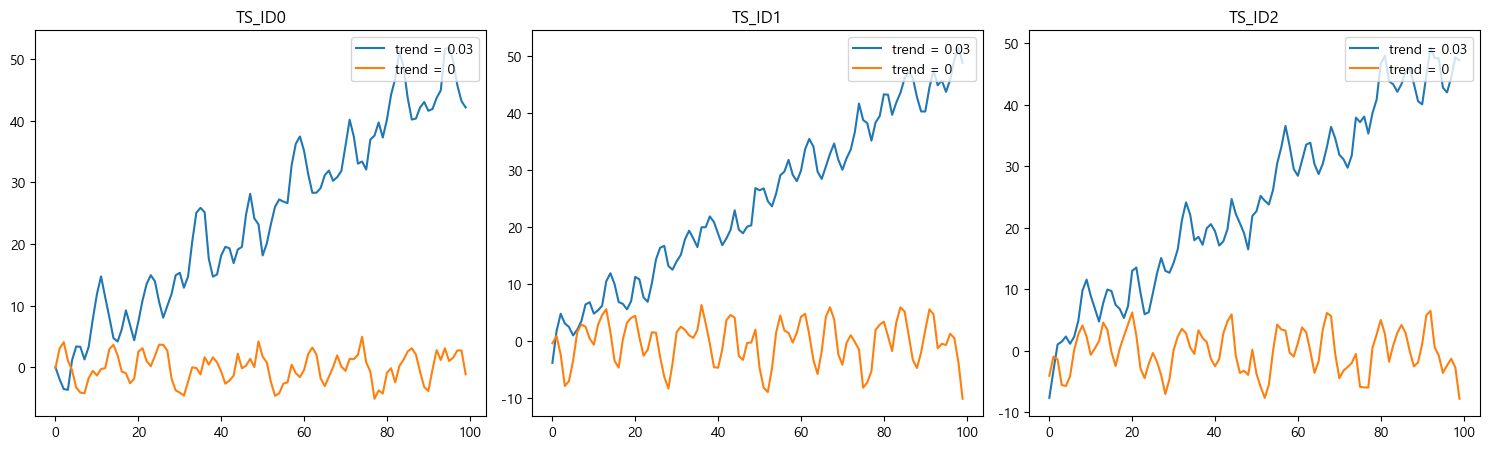

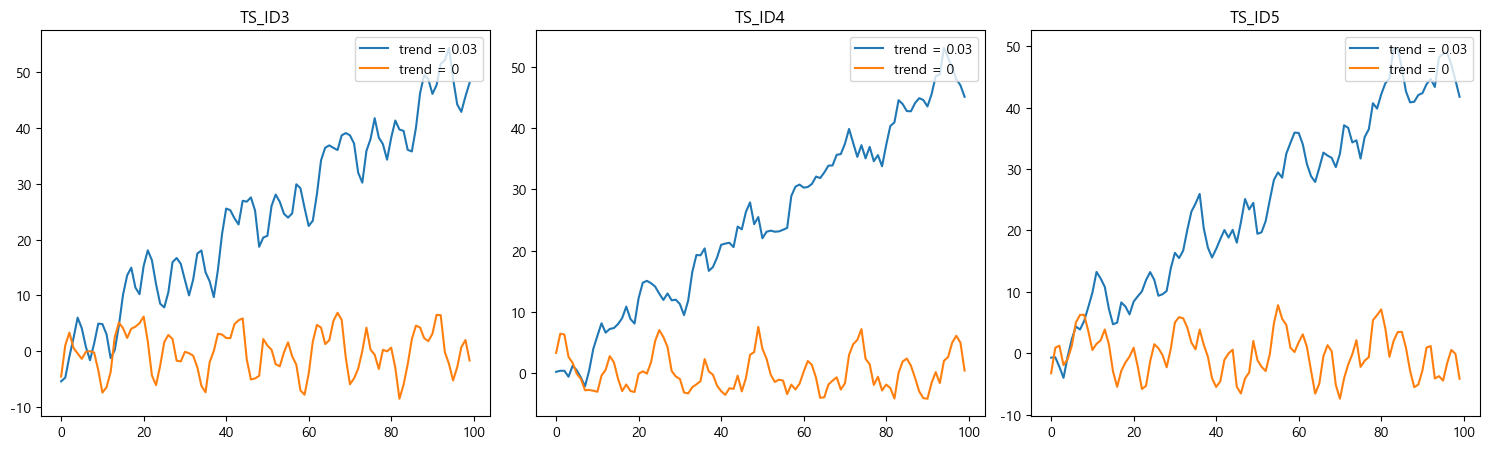

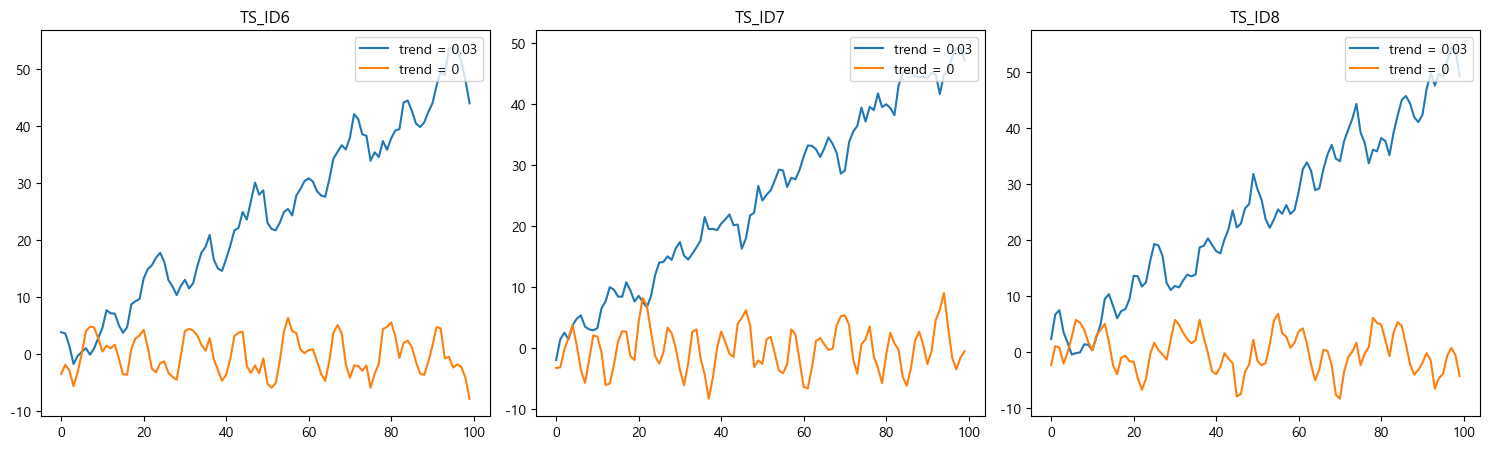

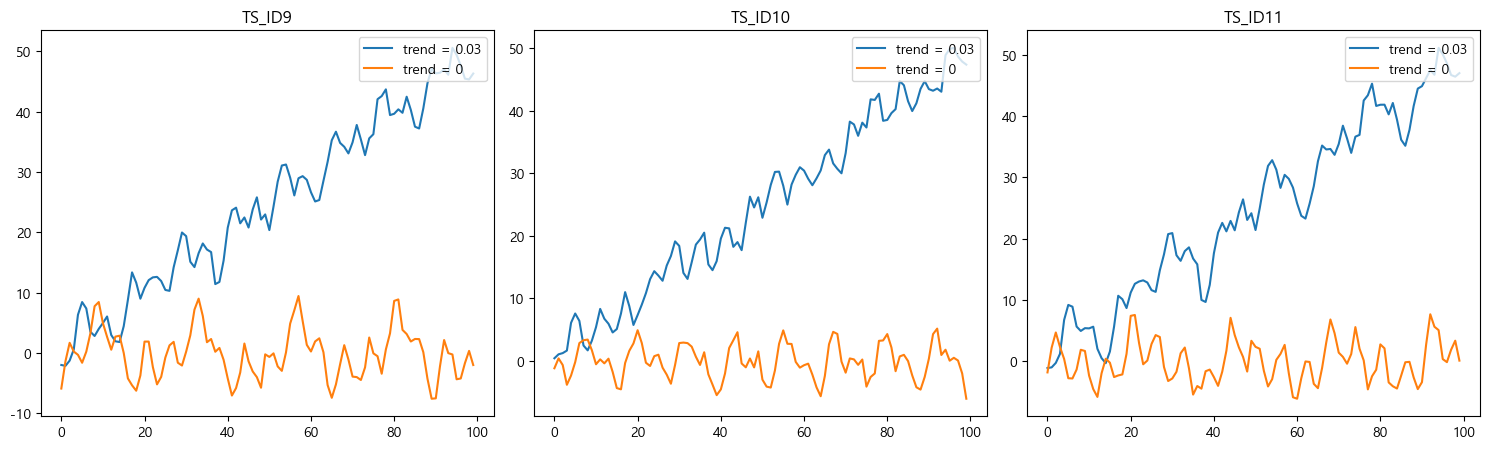

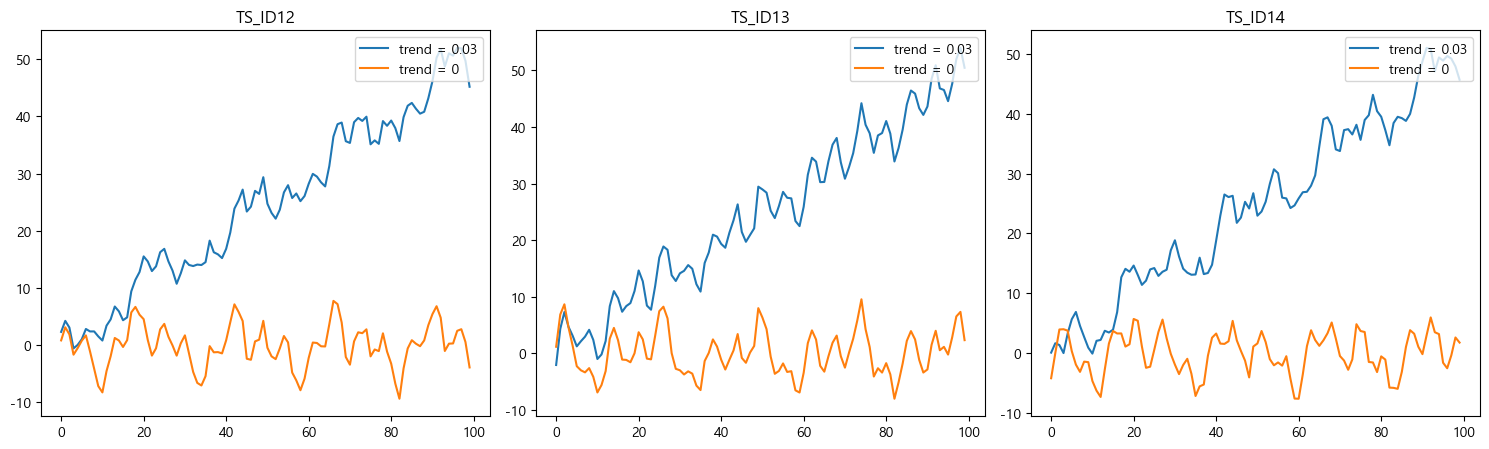

In [72]:
num = 15

def plot_group(start_index):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1행 3열의 서브플롯 생성
    #fig.suptitle(f'Comparison of N-Beats, LSTM predictions, and Actual Data (Groups starting at index {start_index})')

    for i in range(3):
        index = start_index + i
        if index > num-1:
            break
        axs[i].plot(random_simul_yt[index][:100],label = 'trend = 0.03')
        axs[i].plot(random_simul_nt[index][:100],label = 'trend = 0')
        #axs[i].plot(nbeats_pred_lst[0].reshape(-1,15)[i_start[index]:i_end[index]].flatten(),label = 'nbeat');
        #axs[i].plot(lstm_pred_lst[0].reshape(-1,15)[i_start[index]:i_end[index]].flatten(),label = 'lstm');
       # axs[i].plot(y_test_val_solor[i_start[index]:i_end[index]].flatten(),label='obs_y',color = 'black');

        axs[i].legend(loc='upper right')
        axs[i].set_title(f'TS_ID{index}')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    plt.show()


for start_index in range(0, num, 3):
    plot_group(start_index)

## 적합 데이터 시도표2 

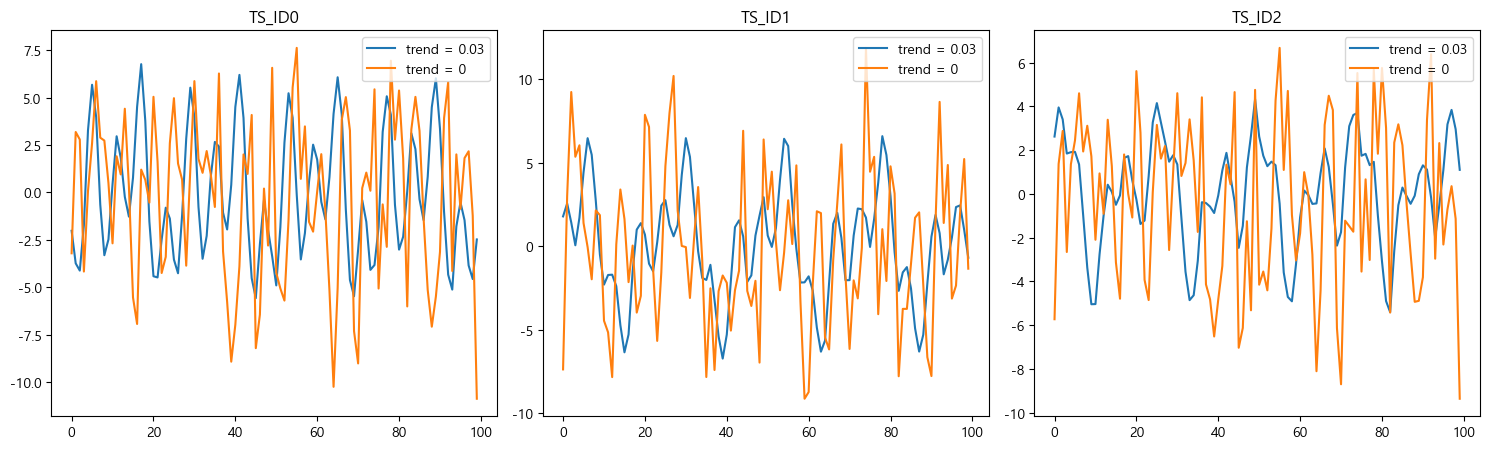

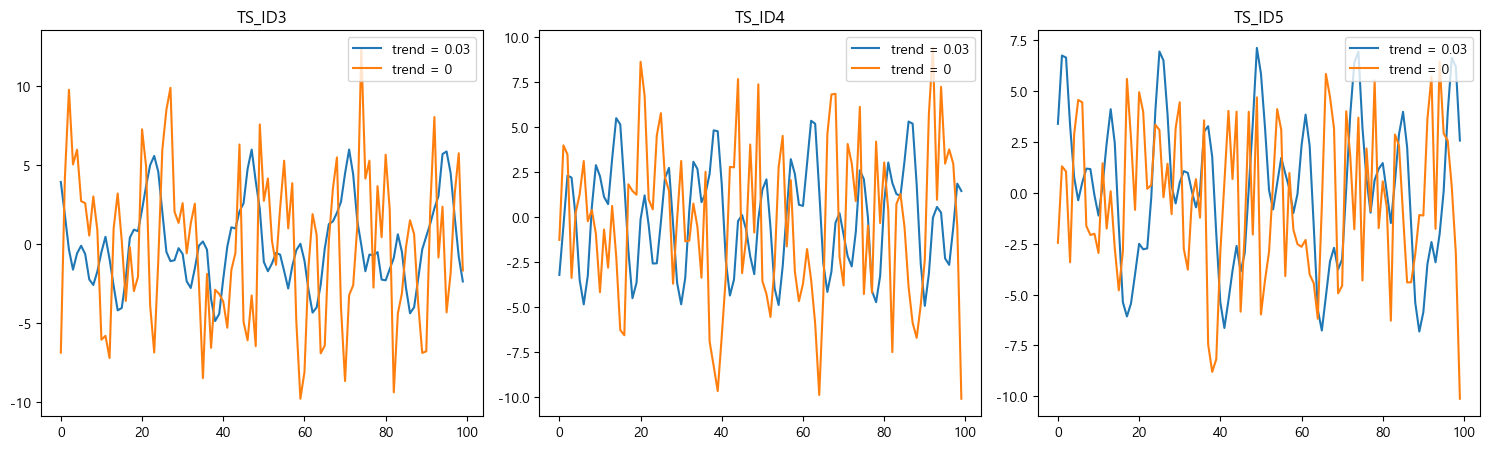

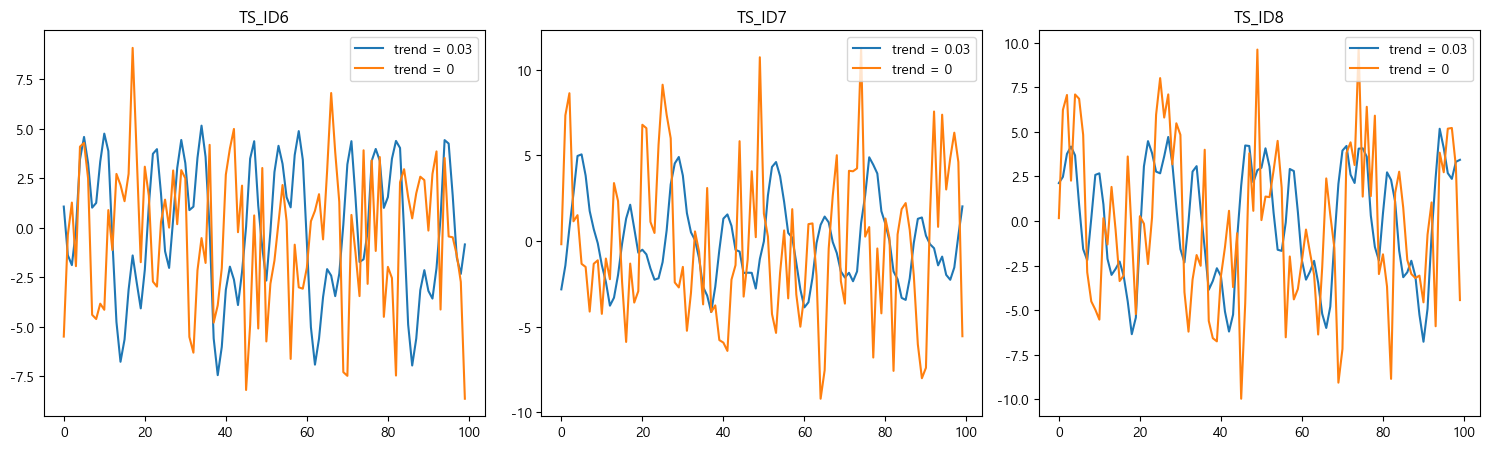

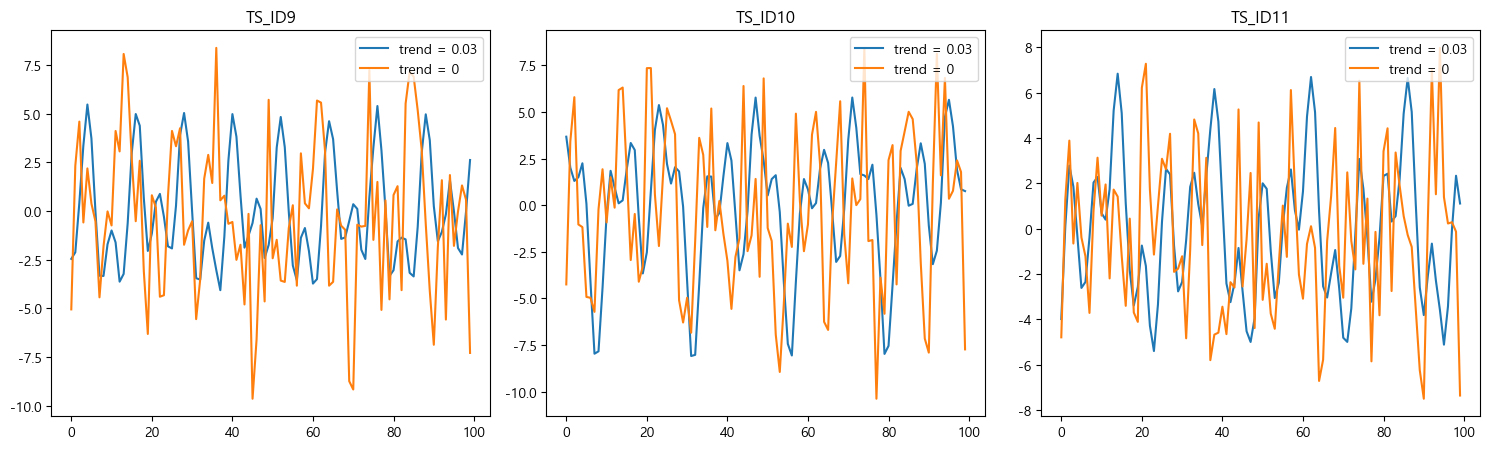

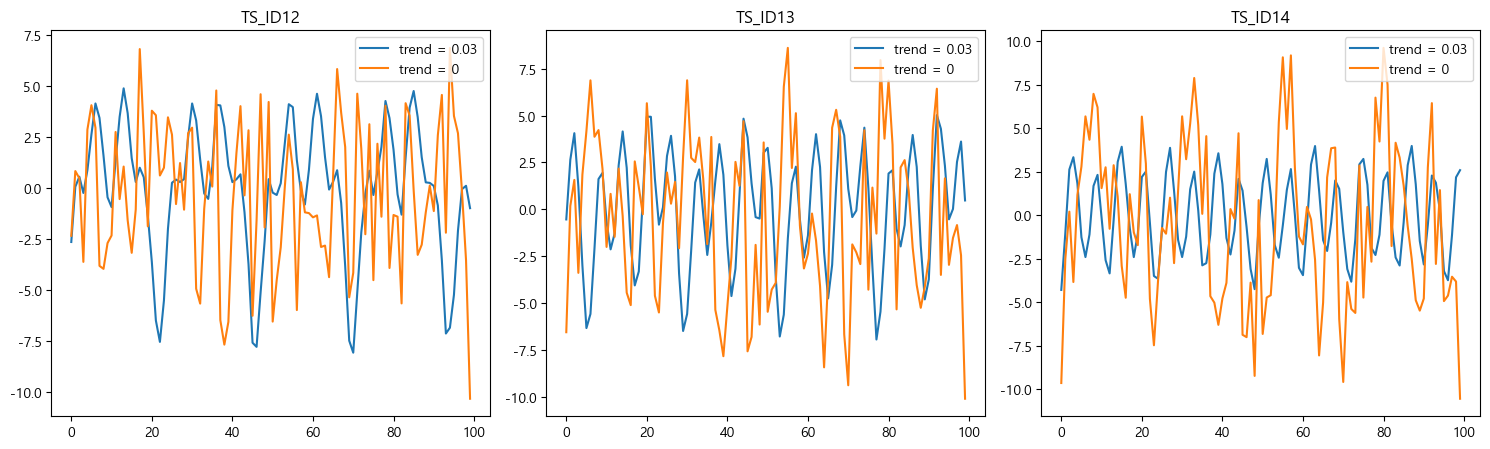

In [74]:
num = 15

def plot_group(start_index):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1행 3열의 서브플롯 생성
    #fig.suptitle(f'Comparison of N-Beats, LSTM predictions, and Actual Data (Groups starting at index {start_index})')

    for i in range(3):
        index = start_index + i
        if index > num-1:
            break
        axs[i].plot(random_simul_le[index][:100],label = 'trend = 0.03')
        axs[i].plot(random_simul_he[index][:100],label = 'trend = 0')
        #axs[i].plot(nbeats_pred_lst[0].reshape(-1,15)[i_start[index]:i_end[index]].flatten(),label = 'nbeat');
        #axs[i].plot(lstm_pred_lst[0].reshape(-1,15)[i_start[index]:i_end[index]].flatten(),label = 'lstm');
       # axs[i].plot(y_test_val_solor[i_start[index]:i_end[index]].flatten(),label='obs_y',color = 'black');

        axs[i].legend(loc='upper right')
        axs[i].set_title(f'TS_ID{index}')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    plt.show()


for start_index in range(0, num, 3):
    plot_group(start_index)

## setting

In [56]:

# nbeats 파라미터
input_dim, output_dim =  1, 1
backcast= horizon*lookback
forecast = horizon #7



def build_model(input_timesteps=backcast, output_timesteps=horizon, features=1):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(input_timesteps, features)))
    # Use Lambda layer to select the last 'output_timesteps' outputs
    model.add(Lambda(lambda x: x[:, -output_timesteps:, :]))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    return model

---
## no trend
---

In [86]:
Num= 15
epoch = 20
batch_size = 4

In [130]:
model_data = [split_train_test([random_simul_nt[i].round(3)],horizon,lookback ) for i in range(len(random_simul_nt))]

In [97]:

##################################################################################################
## sample size = 1000, no trend
#######################################################################################################################################

#X_train,y_train,X_test,y_test = [split_train_test([random_simul_yt[i].round(3)],horizon,lookback ) for i in range(len(random_simul_nt))][0]

nbeats_nt100_score = []
nbeats_nt100_lst = []
nbeats_nt100_time = []



for next_ in range(Num):
    X_train,y_train,X_test,y_test = [split_train_test([random_simul_nt[i].round(3)],horizon,lookback ) for i in range(len(random_simul_nt))][next_]

    K.clear_session()
    model= NBeatsKeras( backcast_length=backcast, forecast_length=forecast, input_dim=input_dim,
                       output_dim=output_dim,stack_types=(NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,
                                                          NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK)
                       ,nb_blocks_per_stack=4, thetas_dim=(1,2,4,4),
                       share_weights_in_stack=True, hidden_layer_units=128)
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=optimizer )

    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=0, restore_best_weights=False)
    #checkpoint = ModelCheckpoint('best_model.h9', monitor='loss', save_best_only=True, mode='max', verbose=1)
    #model.save('best_model.h9')
    nbeat_time1 = time.time()
    history = model.fit(X_train,y_train,
                        epochs=epoch , batch_size=batch_size, verbose=0,
                        callbacks=[early_stop])
    nbeat_time2 = time.time()
    
    pred = model.predict(X_test)
    me1= mean_squared_error(y_test[0].flatten(),pred.flatten())
    me2=mean_absolute_error(y_test[0].flatten(),pred.flatten())
    me3=mean_absolute_percentage_error(y_test[0].flatten(),pred.flatten())
    
    nbeats_nt100_lst.append(pred.flatten())
    nbeats_nt100_score.append([me1,me2,me3])
    nbeats_nt100_time.append(nbeat_time2-nbeat_time1)
    
#######################################################################################################################################


lstm_nt100_score = []
lstm_nt100_lst = []
lstm_nt100_time = []

for i in range(Num):
    X_train,y_train,X_test,y_test = [split_train_test([random_simul_nt[i].round(3)],horizon,lookback ) for i in range(len(random_simul_nt))][next_]

    K.clear_session()
    lstm_model = build_model()
    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
    time1 = time.time()
    history = lstm_model.fit(X_train, y_train,validation_data=(X_test,y_test), 
                        epochs=epoch , batch_size=batch_size, verbose=0, callbacks=[early_stop])
    time2 = time.time()    
    pred = lstm_model.predict(X_test)
    me1= mean_squared_error(y_test[0].flatten(),pred.flatten())
    me2=mean_absolute_error(y_test[0].flatten(),pred.flatten())
    me3=mean_absolute_percentage_error(y_test[0].flatten(),pred.flatten())
    
    lstm_nt100_lst.append(pred.flatten())
    lstm_nt100_score.append([me1,me2,me3])
    lstm_nt100_time.append(time2-time1)
    



1/1 [==============================] - 0s 288ms/step
Epoch 12: early stopping
1/1 [==============================] - 0s 287ms/step


---
## yes trend
---


In [144]:

##################################################################################################
## sample size = 1000, no trend
#######################################################################################################################################

#X_train,y_train,X_test,y_test = [split_train_test([random_simul_yt[i].round(3)],horizon,lookback ) for i in range(len(random_simul_nt))][0]

nbeats_yt100_score = []
nbeats_yt100_lst = []
nbeats_yt100_time = []


for next_ in range(Num):
    X_train,y_train,X_test,y_test = [split_train_test([random_simul_yt[i].round(3)],horizon,lookback ) for i in range(len(random_simul_yt))][next_]

    K.clear_session()
    model= NBeatsKeras( backcast_length=backcast, forecast_length=forecast, input_dim=input_dim,
                       output_dim=output_dim,stack_types=(NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,
                                                          NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK)
                       ,nb_blocks_per_stack=4, thetas_dim=(1,2,4,4),
                       share_weights_in_stack=True, hidden_layer_units=128)
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=optimizer )

    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=0, restore_best_weights=False)
    #checkpoint = ModelCheckpoint('best_model.h9', monitor='loss', save_best_only=True, mode='max', verbose=1)
    #model.save('best_model.h9')
    nbeat_time1 = time.time()
    history = model.fit(X_train,y_train,
                        epochs=epoch , batch_size=batch_size, verbose=0,
                        callbacks=[early_stop])
    nbeat_time2 = time.time()
    
    pred = model.predict(X_test)
    me1= mean_squared_error(y_test[0].flatten(),pred.flatten())
    me2=mean_absolute_error(y_test[0].flatten(),pred.flatten())
    me3=mean_absolute_percentage_error(y_test[0].flatten(),pred.flatten())
    
    nbeats_yt100_lst.append(pred.flatten())
    nbeats_yt100_score.append([me1,me2,me3])
    nbeats_yt100_time.append(nbeat_time2-nbeat_time1)
    
#######################################################################################################################################


lstm_yt100_score = []
lstm_yt100_lst = []
lstm_yt100_time = []

for next_ in range(Num):
    X_train,y_train,X_test,y_test = [split_train_test([random_simul_yt[i].round(3)],horizon,lookback ) for i in range(len(random_simul_yt))][next_]

    K.clear_session()
    lstm_model = build_model()
    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
    time1 = time.time()
    history = lstm_model.fit(X_train, y_train,validation_data=(X_test,y_test), 
                        epochs=epoch , batch_size=batch_size, verbose=0, callbacks=[early_stop])
    time2 = time.time()    
    pred = lstm_model.predict(X_test)
    me1= mean_squared_error(y_test[0].flatten(),pred.flatten())
    me2=mean_absolute_error(y_test[0].flatten(),pred.flatten())
    me3=mean_absolute_percentage_error(y_test[0].flatten(),pred.flatten())
    
    lstm_yt100_lst.append(pred.flatten())
    lstm_yt100_score.append([me1,me2,me3])
    lstm_yt100_time.append(time2-time1)
    

print("종료")

1/1 [==============================] - 0s 277ms/step
종료


In [145]:
pd.DataFrame(np.array([nbeats_yt100_score,lstm_yt100_score]).mean(axis=1))

,0,1,2
0,3.111736,1.397271,0.002374
1,44765.084492,211.446133,0.358900


---
## $\epsilon \sim N(0,1/9)$
---

In [89]:

##################################################################################################
## sample size = 1000, no trend
#######################################################################################################################################

#X_train,y_train,X_test,y_test = [split_train_test([random_simul_yt[i].round(3)],horizon,lookback ) for i in range(len(random_simul_nt))][0]

nbeats_le100_score = []
nbeats_le100_lst = []
nbeats_le100_time = []



for next_ in range(Num):
    X_train,y_train,X_test,y_test = [split_train_test([random_simul_le[i].round(3)],horizon,lookback ) for i in range(len(random_simul_le))][next_]

    K.clear_session()
    model= NBeatsKeras( backcast_length=backcast, forecast_length=forecast, input_dim=input_dim,
                       output_dim=output_dim,stack_types=(NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,
                                                          NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK)
                       ,nb_blocks_per_stack=4, thetas_dim=(1,2,4,4),
                       share_weights_in_stack=True, hidden_layer_units=128)
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=optimizer )

    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=0, restore_best_weights=False)
    #checkpoint = ModelCheckpoint('best_model.h9', monitor='loss', save_best_only=True, mode='max', verbose=1)
    #model.save('best_model.h9')
    nbeat_time1 = time.time()
    history = model.fit(X_train,y_train,
                        epochs=epoch , batch_size=batch_size, verbose=0,
                        callbacks=[early_stop])
    nbeat_time2 = time.time()
    
    pred = model.predict(X_test)
    me1= mean_squared_error(y_test[0].flatten(),pred.flatten())
    me2=mean_absolute_error(y_test[0].flatten(),pred.flatten())
    me3=mean_absolute_percentage_error(y_test[0].flatten(),pred.flatten())
    
    nbeats_le100_lst.append(pred.flatten())
    nbeats_le100_score.append([me1,me2,me3])
    nbeats_le100_time.append(nbeat_time2-nbeat_time1)
    
#######################################################################################################################################


lstm_le100_score = []
lstm_le100_lst = []
lstm_le100_time = []

for i in range(Num):
    X_train,y_train,X_test,y_test = [split_train_test([random_simul_le[i].round(3)],horizon,lookback ) for i in range(len(random_simul_le))][next_]

    K.clear_session()
    lstm_model = build_model()
    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
    time1 = time.time()
    history = lstm_model.fit(X_train, y_train,validation_data=(X_test,y_test), 
                        epochs=epoch , batch_size=batch_size, verbose=0, callbacks=[early_stop])
    time2 = time.time()    
    pred = lstm_model.predict(X_test)
    me1= mean_squared_error(y_test[0].flatten(),pred.flatten())
    me2=mean_absolute_error(y_test[0].flatten(),pred.flatten())
    me3=mean_absolute_percentage_error(y_test[0].flatten(),pred.flatten())
    
    lstm_le100_lst.append(pred.flatten())
    lstm_le100_score.append([me1,me2,me3])
    lstm_le100_time.append(time2-time1)
    


    
print("종료")

1/1 [==============================] - 0s 287ms/step
Epoch 15: early stopping
1/1 [==============================] - 0s 287ms/step
Epoch 15: early stopping
1/1 [==============================] - 0s 286ms/step
Epoch 17: early stopping
1/1 [==============================] - 0s 287ms/step
Epoch 17: early stopping
1/1 [==============================] - 0s 292ms/step
Epoch 16: early stopping
1/1 [==============================] - 0s 287ms/step
종료


In [93]:
[nbeats_le100_score,lstm_le100_score]

[[[0.35679412500093877, 0.4809556191960971, 1.070808819306199],
  [0.3526689336325631, 0.48664583281675977, 2.633695938728278],
  [0.41880987845095374, 0.5636711571415266, 0.5976528030032949],
  [0.3781367624297552, 0.507781780804197, 1.2727058786235486],
  [0.28544148410824943, 0.42735315338770546, 0.4537817711911996],
  [0.5300368166738672, 0.5645805052717527, 0.3929076033929546],
  [1.1968813560112215, 0.9024926977157591, 0.5247354017586945],
  [0.3607797965443211, 0.4629310472408931, 0.5981815465853124],
  [0.6610937541552055, 0.6098855786720913, 0.5824588165972454],
  [0.4488780837586999, 0.585954782684644, 0.7527378549001571],
  [1.0574343834159412, 0.8156021442413331, 1.563823634381106],
  [0.47770003132018735, 0.5369630695382753, 1.1207282383976758],
  [0.2748898173138058, 0.4258409024079641, 2.448703210737358],
  [0.3472141575128502, 0.48497168389956147, 0.4797041020147513],
  [0.23598978214984898, 0.3982585826714833, 0.42743326806147125]],
 [[0.06156559500474726, 0.2015808202

## $\epsilon \sim N(0,9)$

In [90]:

##################################################################################################
## sample size = 1000, no trend
#######################################################################################################################################

#X_train,y_train,X_test,y_test = [split_train_test([random_simul_yt[i].round(3)],horizon,lookback ) for i in range(len(random_simul_nt))][0]

nbeats_he100_score = []
nbeats_he100_lst = []
nbeats_he100_time = []



for next_ in range(Num):
    X_train,y_train,X_test,y_test = [split_train_test([random_simul_he[i].round(3)],horizon,lookback ) for i in range(len(random_simul_he))][next_]

    K.clear_session()
    model= NBeatsKeras( backcast_length=backcast, forecast_length=forecast, input_dim=input_dim,
                       output_dim=output_dim,stack_types=(NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,
                                                          NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK)
                       ,nb_blocks_per_stack=4, thetas_dim=(1,2,4,4),
                       share_weights_in_stack=True, hidden_layer_units=128)
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=optimizer )

    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=0, restore_best_weights=False)
    #checkpoint = ModelCheckpoint('best_model.h9', monitor='loss', save_best_only=True, mode='max', verbose=1)
    #model.save('best_model.h9')
    nbeat_time1 = time.time()
    history = model.fit(X_train,y_train,
                        epochs=epoch , batch_size=batch_size, verbose=0,
                        callbacks=[early_stop])
    nbeat_time2 = time.time()
    
    pred = model.predict(X_test)
    me1= mean_squared_error(y_test[0].flatten(),pred.flatten())
    me2=mean_absolute_error(y_test[0].flatten(),pred.flatten())
    me3=mean_absolute_percentage_error(y_test[0].flatten(),pred.flatten())
    
    nbeats_he100_lst.append(pred.flatten())
    nbeats_he100_score.append([me1,me2,me3])
    nbeats_he100_time.append(nbeat_time2-nbeat_time1)
    
#######################################################################################################################################


lstm_he100_score = []
lstm_he100_lst = []
lstm_he100_time = []

for i in range(Num):
    X_train,y_train,X_test,y_test = [split_train_test([random_simul_he[i].round(3)],horizon,lookback ) for i in range(len(random_simul_he))][next_]

    K.clear_session()
    lstm_model = build_model()
    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
    time1 = time.time()
    history = lstm_model.fit(X_train, y_train,validation_data=(X_test,y_test), 
                        epochs=epoch , batch_size=batch_size, verbose=0, callbacks=[early_stop])
    time2 = time.time()    
    pred = lstm_model.predict(X_test)
    me1= mean_squared_error(y_test[0].flatten(),pred.flatten())
    me2=mean_absolute_error(y_test[0].flatten(),pred.flatten())
    me3=mean_absolute_percentage_error(y_test[0].flatten(),pred.flatten())
    
    lstm_he100_lst.append(pred.flatten())
    lstm_he100_score.append([me1,me2,me3])
    lstm_he100_time.append(time2-time1)
    


    
print("종료")

1/1 [==============================] - 0s 295ms/step
종료


---
# 결과 정리
---

## 1. 샘플사이즈에 따른 적절한 에포크
- 배치사이즈 = 4로 고정
- 에포크 20으로 실험

---
## 2. 추세의 유무에 따른 random TS 모델의 예측 결과

### 2.1 추세성 x , 15개의 타임시리즈 평가지표의 평균

In [124]:
trend_n15_nbeat= pd.DataFrame(pd.DataFrame(nbeats_nt100_score).mean(axis=0)).T#,lstm_nt100_score])
trend_n15_lstm= pd.DataFrame(pd.DataFrame(lstm_nt100_score).mean(axis=0)).T#,lstm_nt100_score])
trend_n= pd.concat([trend_n15_nbeat,trend_n15_lstm],axis=0)
trend_n.columns = ['MSE','MAE','MAPE']
trend_n.index = ['nbeats','lstm']
trend_n

,MSE,MAE,MAPE
nbeats,1.408732,0.956780,4.077594
lstm,1.535211,0.979665,1.019790


### 2.2 추세성 o , 15개의 타임시리즈 평가지표의 평균

In [146]:
trend_y15_nbeat= pd.DataFrame(pd.DataFrame(nbeats_yt100_score).mean(axis=0)).T#,lstm_nt100_score])
trend_y15_lstm= pd.DataFrame(pd.DataFrame(lstm_yt100_score).mean(axis=0)).T#,lstm_nt100_score])
trend_y= pd.concat([trend_y15_nbeat,trend_y15_lstm],axis=0)
trend_y.columns = ['MSE','MAE','MAPE']
trend_y.index = ['nbeats','lstm']
trend_y

,MSE,MAE,MAPE
nbeats,3.111736,1.397271,0.002374
lstm,44765.084492,211.446133,0.358900


---
## 3. 잔차의 크기에 따른 random TS 모델의 예측 결과

### 3.1 $\epsilon \sim N(0,\frac{1}{3^2})$

In [147]:
low_e15_nbeat= pd.DataFrame(pd.DataFrame(nbeats_le100_score).mean(axis=0)).T#,lstm_nt100_score])
low_e15_lstm= pd.DataFrame(pd.DataFrame(lstm_le100_score).mean(axis=0)).T#,lstm_nt100_score])
low_e= pd.concat([low_e15_nbeat,low_e15_lstm],axis=0)
low_e.columns = ['MSE','MAE','MAPE']
low_e.index = ['nbeats','lstm']
low_e

,MSE,MAE,MAPE
nbeats,0.492183,0.550259,0.994671
lstm,0.071628,0.219046,0.270087


### 3.2 $\epsilon \sim N(0,3^2)$

In [149]:
high_e15_nbeat= pd.DataFrame(pd.DataFrame(nbeats_he100_score).mean(axis=0)).T#,lstm_nt100_score])
high_e15_lstm= pd.DataFrame(pd.DataFrame(lstm_he100_score).mean(axis=0)).T#,lstm_nt100_score])
high_e= pd.concat([high_e15_nbeat,high_e15_lstm],axis=0)
high_e.columns = ['MSE','MAE','MAPE']
high_e.index = ['nbeats','lstm']
high_e

,MSE,MAE,MAPE
nbeats,10.976723,2.709967,1.944782
lstm,17.011443,3.253353,1.777653
